In [25]:
%%writefile 'Artigos.py'
from Definitions import *
class Artigos():
    
    def __init__(self, raiz = os.getcwd(), biblioteca=['esporte', 'politica', 'tecnologia']):
        
        self.raiz = raiz
        self.biblioteca = biblioteca 
        nltk.download('stopwords')
        self.campo_conteudo = ['assunto', 'texto', 'data', 'titulo']
    
        self.lista_stopwords = nltk.corpus.stopwords.words('portuguese')
        self.lista_pontuacao = string.punctuation

        
        for assunto in biblioteca:
            
            caminho = os.path.join(self.raiz, assunto)
            
            if not os.path.isdir(caminho):
            
                os.mkdir(caminho)
         
    
    def __retira_pontuacao__(self, texto='a vaca, é amarela!!! a a a'):
       
        for pontuacao in self.lista_pontuacao:
            texto = texto.replace(pontuacao, '')
        
        return texto
    
    def __retira_stopwords__(self, texto = "a vaca, é amarela!!!! a a a"):
    
        lista_palavras = texto.split()
        nova_lista_palavras = []
    
        for  palavra in lista_palavras:
        
            palavra = palavra.strip()
        
            eh_stopwords = palavra in self.lista_stopwords
            na_lista = palavra in nova_lista_palavras
            
            if (not eh_stopwords) and (not na_lista):        
                nova_lista_palavras.append(palavra)
    
        return nova_lista_palavras

        
    def __ajuste_titulo__(self, titulo):
        return "_".join(titulo.split(' '))
    
    def __filtro_palavras__(self, texto='a vaca, é amarela!!! a a a'):
        
        texto_sem_pontuacao = self.__retira_pontuacao__(texto = texto)
        lista_palavras = self.__retira_stopwords__(texto = texto_sem_pontuacao)
    
        return lista_palavras
    
    def __relacao_entre_textos__(self, texto_artigo1, texto_artigo2):
    
        lista_palavras1 = self.__filtro_palavras__(texto_artigo1)
        lista_palavras2 = self.__filtro_palavras__(texto_artigo2)

        lista_palavras_contidas = list(filter(lambda palavra: palavra in lista_palavras2, lista_palavras1))
        porcentagem_palavras_contidas = len(lista_palavras_contidas)/len(lista_palavras1)

        return porcentagem_palavras_contidas
    
    def __pega_artigos__(self, *campo_solicitado,  biblioteca = []):
        
        biblioteca = self.biblioteca
    
        pacote = []

        for assunto in biblioteca:

            assunto_diretorio = os.path.join(self.raiz, assunto)

            for artigo in os.listdir(assunto_diretorio):

                caminho_artigo = os.path.join(assunto_diretorio, artigo)

                if '.ipynb_checkpoints' not in caminho_artigo:

                    with open(caminho_artigo, 'r') as artigo_json:

                        artigo_dicionario = json.loads(artigo_json.read())
                       
                        for topico in self.campo_conteudo:
                            if topico not in campo_solicitado:
                                artigo_dicionario.pop(topico, None)
                    
                        pacote.append(artigo_dicionario)

        os.chdir(self.raiz)
        return pacote
   
    def __separa_artigos__(self, titulo_artigo, conjuto_artigos):
        
        artigo_referencia = list(filter(lambda artigo: artigo['titulo'] == titulo_artigo, conjuto_artigos))
         
        artigo_referencia = artigo_referencia[0]
        
        demais_artigos = list(filter(lambda artigo: artigo['titulo'] != titulo_artigo, conjuto_artigos))
        
        return artigo_referencia, demais_artigos
    
    
    
    def __pega_porcentagem_entre_textos__(self, titulo_artigo='a vaca amarela'):

        
        conjuto_artigos = self.__pega_artigos__('titulo', 'texto')
        
        artigo_referencia, demais_artigos = self.__separa_artigos__(titulo_artigo = titulo_artigo, conjuto_artigos=conjuto_artigos)
        
        pacote = []
        
        
        for outro_artigo in demais_artigos:
            
            similaridade_com_texto = {}
            porcentagem_relacao = self.__relacao_entre_textos__(artigo_referencia['texto'], outro_artigo['texto'])
            similaridade_com_texto['titulo'] = outro_artigo['titulo']
            similaridade_com_texto['valor'] = porcentagem_relacao
            pacote.append(similaridade_com_texto)
            
        return pacote    
    
    def melhor_indicacao(self, titulo_artigo='a vaca amarela'):
    
        api = gerenciador.__pega_porcentagem_entre_textos__(titulo_artigo = titulo_artigo)

        indicacoes = sorted(api, key=lambda relacao_artigos: relacao_artigos['valor'])
        
        return indicacoes[0]
    
    def adicionar_artigo(self, **artigo):
        
        print(artigo)
        
        if artigo['assunto'] not in self.biblioteca:
            raise AssuntoNotFound
            
        novo_artigo = {}
        
        artigo['titulo'] = artigo['titulo'].lower()
        
        titulo_sem_espacos = self.__ajuste_titulo__(artigo['titulo'])
        
        novo_artigo['titulo'] = artigo['titulo']
        novo_artigo['data'] = artigo['data']
        novo_artigo['assunto'] = artigo['assunto']
        novo_artigo['texto'] = artigo['texto']
        
        arquivo_json = json.dumps(novo_artigo, indent = 4)
        
        diretorio_novo_arquivo = os.path.join(self.raiz, artigo['assunto'], titulo_sem_espacos + '.txt' )
        
        with open(diretorio_novo_arquivo, 'w') as arquivo:
            arquivo.writelines(arquivo_json)
        
#         print(novo_artigo)
        
        
    def consultar_por_data(self, reverse = False):
        
        pacote = self.__pega_artigos__('data', 'titulo', 'assunto')
        api = sorted(pacote, key=lambda artigo: artigo['data'])
        
        if reverse:
            api.reverse()
            return api
        
        else:
            return api

    def criar_grafo(self, titulo_artigo='a vaca amarela'):
    
        grafo = nx.Graph()

        lista_relacoes = self.__pega_porcentagem_entre_textos__(titulo_artigo)

        arestas = []

        for artigo in lista_relacoes:
            dados_relacao = (titulo_artigo, artigo['titulo'], artigo['valor'])
            arestas.append(dados_relacao)

        grafo.add_weighted_edges_from(arestas)

        pos = nx.spring_layout(grafo, seed=42)

        nx.draw(grafo, pos, with_labels=True)

        atributo_arestas = nx.get_edge_attributes(grafo, 'weight')
        nx.draw_networkx_edge_labels(grafo, pos, edge_labels=atributo_arestas)
        plt.show()


### Testes da classe


#### criação da classe

In [5]:
print(os.getcwd())
raiz = os.getcwd()
gerenciador = Artigos(raiz)

C:\Users\Acer\OneDrive\Estudos\UFPE\2020.2\Santander\Santander coders\Indicador_de_artigos\Classes


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Adicionando um artigo


In [24]:
raiz = os.getcwd()
gerenciador = Artigos(raiz)
artigo = {}
artigo['titulo'] = 'a vaca amarela'
artigo['assunto'] = 'politica'
artigo['data'] = '13/02/1999'
artigo['texto'] = 'a vaca amarela caminhou até a venda'
gerenciador.adicionar_artigo(**artigo)


{'titulo': 'a vaca amarela', 'assunto': 'politica', 'data': '13/02/1999', 'texto': 'a vaca amarela caminhou até a venda'}


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Ordenando por datas


In [15]:
raiz = os.getcwd()
gerenciador = Artigos(raiz)
api = gerenciador.consultar_por_data(True)
print(api)


[{'titulo': 'a vaca amarela5', 'data': '13/05/1999', 'assunto': 'politica'}, {'titulo': 'a vaca amarela1', 'data': '13/05/1999', 'assunto': 'politica'}, {'titulo': 'a vaca amarela6', 'data': '13/02/1999', 'assunto': 'politica'}, {'titulo': 'a vaca amarela2', 'data': '13/02/1999', 'assunto': 'politica'}, {'titulo': 'a vaca amarela', 'data': '13/02/1999', 'assunto': 'politica'}]


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Retirando pontuacao do texto

In [8]:
gerenciador = Artigos(raiz)
resultado = gerenciador.__retira_pontuacao__()
print(resultado)
    

a vaca é amarela a a a


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Retirando stopwords

In [9]:
gerenciador = Artigos(raiz)
texto = "a vaca, é amarela!!!! a a a"
lista_palavras1 = gerenciador.__retira_stopwords__(texto)
print(lista_palavras1)


['vaca,', 'amarela!!!!']


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Filtrar palavras

In [10]:
gerenciador = Artigos()
lista_palavras = gerenciador.__filtro_palavras__()
print(lista_palavras)

['vaca', 'amarela']


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Relacao entre os textos

In [11]:
gerenciador = Artigos()
texto1 = 'estavamos todos dentro de casa'
texto2 = 'estavamos todos dentro na rua, logo em seguida um cachorro nos atacou'

resultado = gerenciador.__relacao_entre_textos__(texto1, texto2)
print(resultado)

resultado2 = gerenciador.__relacao_entre_textos__(texto2, texto1)
print(resultado2)
        

0.75
0.375


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Obtem dados para a indicação
utilizando a função relacao entre os textos você deve calcular a porcentagem de relacao entre todos os textos da biblioteca

In [12]:
gerenciador = Artigos()
api = gerenciador.__pega_porcentagem_entre_textos__(titulo_artigo='a vaca amarela')
print(api)      


[{'titulo': 'a vaca amarela1', 'valor': 1.0}, {'titulo': 'a vaca amarela2', 'valor': 1.0}, {'titulo': 'a vaca amarela5', 'valor': 1.0}, {'titulo': 'a vaca amarela6', 'valor': 1.0}]


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Indicação

método que indicara a melhor opção para o usuário

In [13]:
gerenciador = Artigos()
melhor_indicacao = gerenciador.melhor_indicacao(titulo_artigo='a vaca amarela')
print(melhor_indicacao)

{'titulo': 'a vaca amarela1', 'valor': 1.0}


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!




#### Criar grafo 

analise visual das relações entre os artigos

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


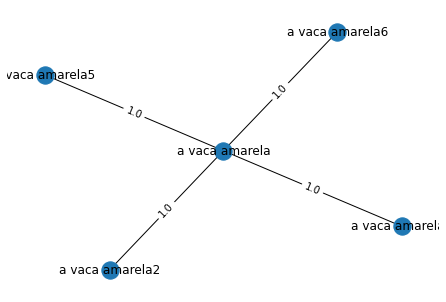

In [14]:
gerenciador = Artigos()
gerenciador.criar_grafo(titulo_artigo='a vaca amarela')